Применим знания на практике: с помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse as ph

sns.set(
       font_scale=1, 
       style='whitegrid', 
       rc={'figure.figsize':(12,8)}
       )

Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
query = """
SELECT count(*)
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,count()
0,85207


Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь;
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [4]:
query = """
SELECT sum(toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) AS price , room_type, id
FROM ldn_listings
GROUP BY room_type, id
ORDER BY id ASC
LIMIT 1000
"""
df_2 = ph.read_clickhouse(query, connection=connection_default)
df_2

,price,room_type,id
0,65.0,Private room,13913
1,100.0,Entire home/apt,15400
2,300.0,Entire home/apt,17402
3,150.0,Private room,17506
4,65.0,Entire home/apt,25023
...,...,...,...
995,110.0,Entire home/apt,541081
996,110.0,Entire home/apt,541363
997,65.0,Private room,542231
998,100.0,Entire home/apt,542646


In [5]:
df_2 = df_2.groupby('room_type', as_index=False)\
           .price.quantile(q=0.75)

In [6]:
df_2

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [7]:
query = """
SELECT sum(toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) AS price, 
        room_type, 
        toFloat32OrNull(review_scores_rating) AS scores_rating,
        id
FROM ldn_listings
GROUP BY room_type, review_scores_rating, id  
HAVING scores_rating != 0 AND scores_rating != 'NaN'
ORDER BY id
LIMIT 1000
"""
df_3 = ph.read_clickhouse(query, connection=connection_default)
df_3

,price,room_type,scores_rating,id
0,65.0,Private room,97.0,13913
1,100.0,Entire home/apt,96.0,15400
2,300.0,Entire home/apt,94.0,17402
3,65.0,Entire home/apt,93.0,25023
4,29.0,Private room,96.0,25123
...,...,...,...,...
995,165.0,Entire home/apt,100.0,616278
996,99.0,Private room,93.0,617678
997,45.0,Private room,100.0,618082
998,20.0,Private room,88.0,619010


In [8]:
df_3 = df_3.groupby('room_type', as_index=False)\
            .agg({'price': 'mean', 'scores_rating': 'mean'})
df_3

,room_type,price,scores_rating
0,Entire home/apt,135.882957,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642436,94.766205
3,Shared room,21.000000,90.000000


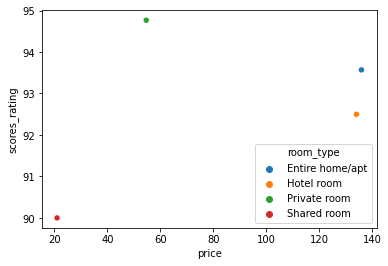

In [9]:
sns.scatterplot(data=df_3, x='price', y='scores_rating', hue='room_type')

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль
Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']


2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [10]:
query = """
SELECT DISTINCT host_id, host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df_4 = ph.read_clickhouse(query, connection=connection_default)
df_4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [11]:
df_4['host_verifications'] = df_4.host_verifications\
                                .apply(lambda x: str(x).strip().replace('[', '').replace(']', '').replace(',', '').split())
df_4.host_verifications.explode().value_counts()                                

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [12]:
query = """
SELECT neighbourhood_cleansed, experiences_offered, count(id) AS experiences_count 
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df_5 = ph.read_clickhouse(query, connection=connection_default)
df_5

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [13]:
df_5_pivot = df_5.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
df_5_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


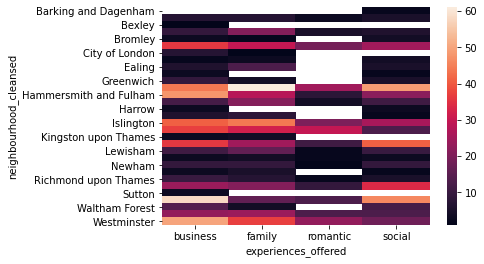

In [16]:
cmap=sns.cubehelix_palette(as_cmap=True)
ax = sns.heatmap(df_5_pivot)

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')

Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [17]:
query = """
SELECT sum(toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) AS price, 
        room_type
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY room_type, review_scores_rating, id  
ORDER BY id
"""
df_6 = ph.read_clickhouse(query, connection=connection_default)
df_6

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,150.0,Private room
3,45.0,Private room
4,25.0,Private room
...,...,...
1543,100.0,Entire home/apt
1544,125.0,Entire home/apt
1545,185.0,Entire home/apt
1546,110.0,Entire home/apt


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


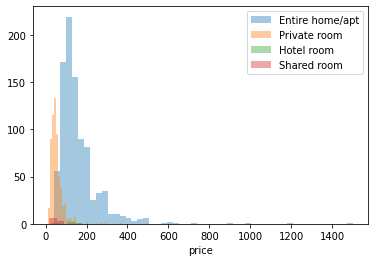

In [18]:
sns.distplot(df_6.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df_6.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df_6.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df_6.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

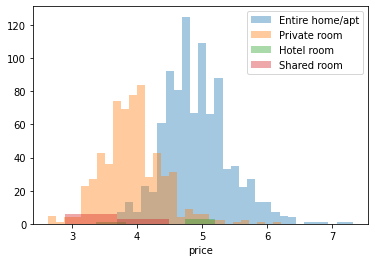

In [19]:
sns.distplot(np.log(df_6.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_6.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_6.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df_6.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [20]:
query = """
SELECT sum(toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) AS price, 
        room_type,
        first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
GROUP BY room_type, first_review, id
ORDER BY id
LIMIT 1000
"""
df_7 = ph.read_clickhouse(query, connection=connection_default)
df_7

,price,room_type,first_review
0,65.0,Private room,2010-08-18
1,300.0,Entire home/apt,2011-03-21
2,65.0,Entire home/apt,2016-03-05
3,29.0,Private room,2010-04-14
4,100.0,Private room,2010-10-16
...,...,...,...
995,45.0,Private room,2012-11-07
996,51.0,Private room,2013-03-18
997,79.0,Entire home/apt,2012-09-17
998,110.0,Entire home/apt,2012-09-24


In [25]:
df_7['year'] = df_7.first_review.apply(lambda x: x[:4])
df_7

,price,room_type,first_review,year
0,65.0,Private room,2010-08-18,2010
1,300.0,Entire home/apt,2011-03-21,2011
2,65.0,Entire home/apt,2016-03-05,2016
3,29.0,Private room,2010-04-14,2010
4,100.0,Private room,2010-10-16,2010
...,...,...,...,...
995,45.0,Private room,2012-11-07,2012
996,51.0,Private room,2013-03-18,2013
997,79.0,Entire home/apt,2012-09-17,2012
998,110.0,Entire home/apt,2012-09-24,2012


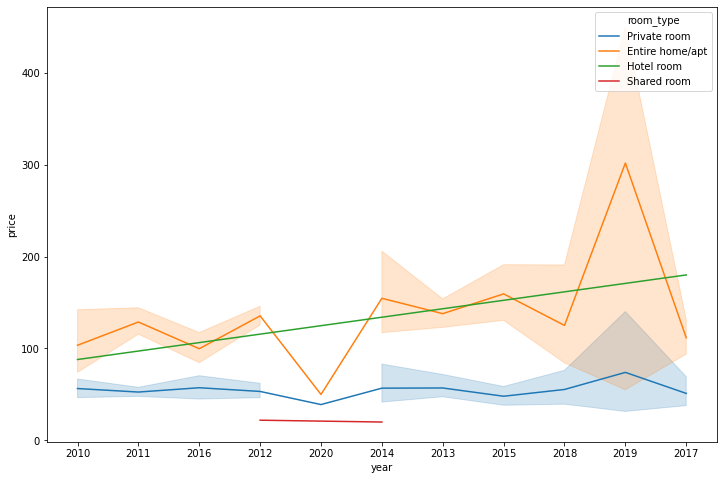

In [24]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='price', hue='room_type', data=df_7)